In [1]:
from typing import List, Tuple
from tqdm import tqdm
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [2]:
file_names = ["1", "2", "3", "4", "5", "6", "7"]
path = "resources/"
extension = ".txt"
files = [path + file_name + extension for file_name in file_names]


In [3]:
class Dataset(object):
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = np.array(x_train)
        self.y_train = np.array(y_train)
        self.x_test = np.array(x_test)
        self.y_test = np.array(y_test)
    
    def attributes_num(self):
        return self.x_train.shape[1]

class Graph(object):
    def __init__(self, x_axis=[], y_axis=[]):
        self.x_axis = x_axis
        self.y_axis = y_axis
    
    def add_point(self, x, y):
        self.x_axis.append(x)
        self.y_axis.append(y)

In [4]:
def read_dataset_from_file(filename):
    file = open(filename, 'r')
    m = int(file.readline())
    n_train = int(file.readline())
    objects_train = []
    labels_train = []
    rows = []
    for _ in range(n_train):
        obj = [float(x) for x in file.readline().split()]
        rows.append(obj)
    for row in rows:
        label = row.pop()
        objects_train.append(row + [1.])
        labels_train.append(label)

    n_test = int(file.readline())
    
    objects_test: List[List[int]] = []
    labels_test: [List[int]] = []
    rows = []
    for _ in range(n_test):
        obj = [float(x) for x in file.readline().split()]
        rows.append(obj)
    for row in rows:
        label = row.pop()
        objects_test.append(row + [1.])
        labels_test.append(label)
    file.close()
    return Dataset(objects_train, labels_train, objects_test, labels_test)

In [5]:
def nrmse(X, y, w):
    pred = X @ w
    sum_errors = sum([(y1 - y2) ** 2 for (y1, y2) in zip(y, pred)])
    return np.sqrt(sum_errors / len(y)) / (np.max(y) - np.min(y))


In [6]:
def compute_stochastic_gradient(X_i, y_i, w, lambda_reg):
    return 2 * (np.dot(w, X_i) - y_i) * X_i + 2 * lambda_reg * w

def learning_rate(grad, X_i, y_i, w):
    diffs = np.dot(X_i, w.T) - y_i
    scalar_products = np.transpose(X_i @ grad.T)
    s = np.sum(np.square(scalar_products))
    if s == 0:
        return 0
    else:
        return np.dot(diffs, scalar_products) / s

In [7]:
def do_gradient(x, y, steps_limit, lambda_reg=1):
    graph = Graph([], [])
    m = len(x[0]) - 1
    w =  np.array([random.uniform(-1./(2 * m), 1./(2 * m)) for _ in range(m + 1)])
    for step in range(steps_limit):
        i = random.randint(0, len(x) - 1)
        X_i = x[i]
        y_i = y[i]
        grad = compute_stochastic_gradient(X_i, y_i, w, lambda_reg)
        mu = learning_rate(grad, X_i, y_i, w) / (step + 1)
        w = w * (1 - mu * lambda_reg) - grad * mu
        err = nrmse(x, y, w)
        graph.add_point(step, err)
    return graph

In [8]:
def gradient_with_lambda(x, y, lambda_reg):
    graph = do_gradient(x, y, 2000, lambda_reg)
    err = graph.y_axis[-1]
    return err, graph

    
def handle_file(file):
    dataset = read_dataset_from_file(file)
    lambda_regs = [1e-5, 1e-2, 1e-1, 1, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    best_graph = Graph([], [])
    best_err = 9999999
    best_lambda = 0
    for lambda_reg in tqdm(lambda_regs):
        cur_err, _ = gradient_with_lambda(dataset.x_train, dataset.y_train, lambda_reg)
        if cur_err < best_err:
            best_err = cur_err
            best_lambda = lambda_reg
    print(f'Best lambda: {best_lambda}')
    _, graph1 = gradient_with_lambda(dataset.x_train, dataset.y_train, best_lambda)
    _, graph2 = gradient_with_lambda(dataset.x_test, dataset.y_test, best_lambda)
    plt.plot(graph1.x_axis, graph1.y_axis)
    plt.show()
    plt.plot(graph2.x_axis, graph2.y_axis)
    plt.show()

100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Best lambda: 80


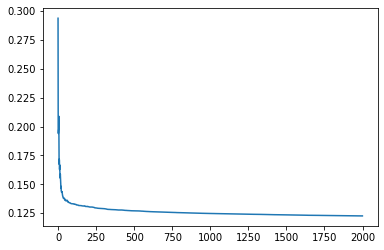

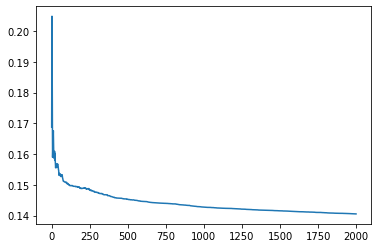

In [9]:
handle_file(files[0])

100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


Best lambda: 30


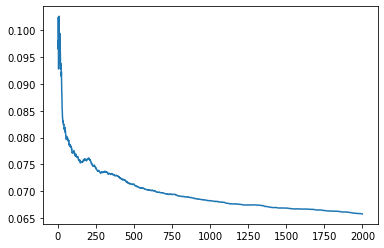

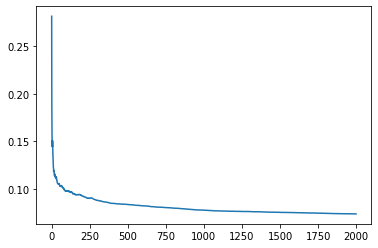

In [10]:
handle_file(files[1])

100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


Best lambda: 15


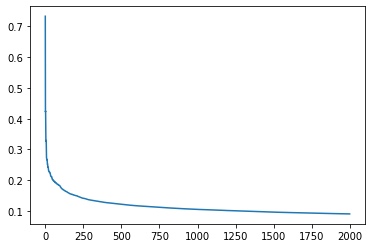

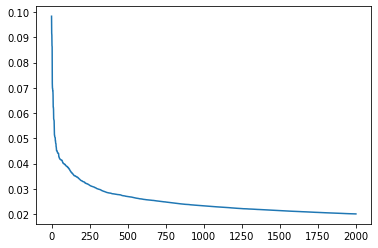

In [11]:
handle_file(files[2])

100%|██████████| 15/15 [01:48<00:00,  7.23s/it]


Best lambda: 10


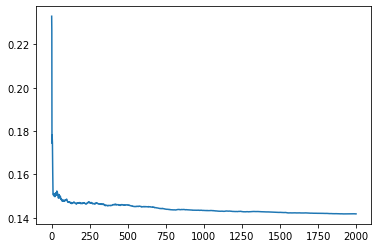

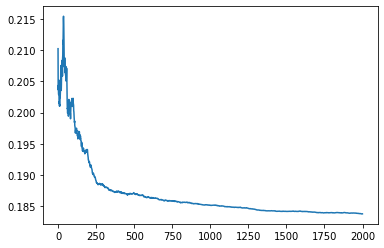

In [12]:
handle_file(files[3])

100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Best lambda: 100


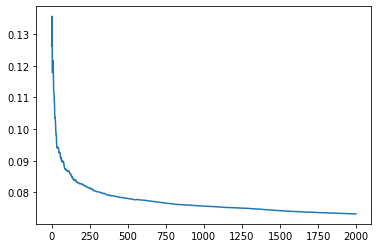

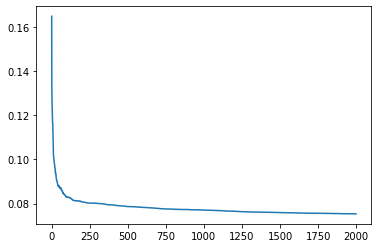

In [13]:
handle_file(files[4])

100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Best lambda: 0.1


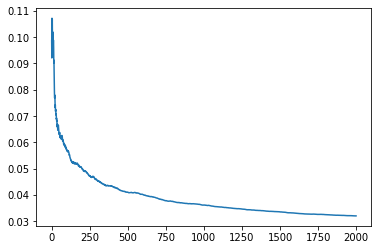

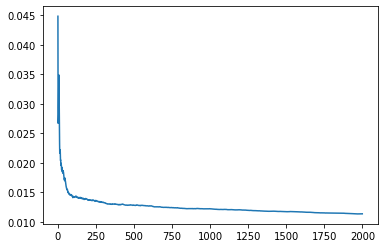

In [14]:
handle_file(files[5])

100%|██████████| 15/15 [01:20<00:00,  5.35s/it]


Best lambda: 40


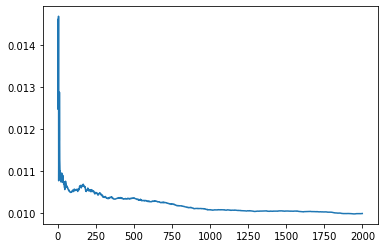

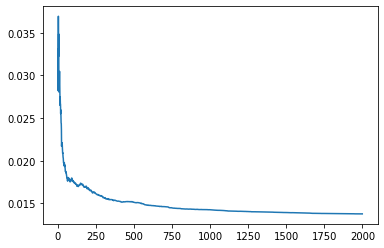

In [15]:
handle_file(files[6])

In [16]:
def lsm_regularized(X, y, lambda_reg):
    n = X.shape[1]
    r = np.linalg.matrix_rank(X)
    U, sigma, VT = linalg.svd(X, full_matrices=False)
    coefs = (sigma[:r] / (sigma[:r] ** 2  + lambda_reg))
   
    D_plus = np.diag(np.hstack([coefs, np.zeros(n - r)]))
    V = VT.T
    if V.shape[1] != D_plus.shape[0]:
        V = VT
    X_plus = V.dot(D_plus).dot(U.T)
    w = X_plus.dot(y)
    return nrmse(X, y, w)
    
    
def handle_file_lsm(file):
    dataset = read_dataset_from_file(file)
    lambda_regs = [0, 1e-5, 1e-2, 1e-1] + list(range(1, 100))
    best_lambda = 0
    best_err = 9999999
    for lambda_reg in tqdm(lambda_regs):
        err = lsm_regularized(dataset.x_train, dataset.y_train, lambda_reg)
        if err < best_err:
            best_err = err
            best_lambda = lambda_reg
    print(f'Best lambda: {best_lambda}, Best nrmse: {best_err}')


In [ ]:
handle_file_lsm(files[0])

  2%|▏         | 2/103 [00:00<00:13,  7.67it/s]

In [ ]:
handle_file_lsm(files[1])

In [ ]:
handle_file_lsm(files[2])

In [ ]:
handle_file_lsm(files[3])

In [ ]:
handle_file_lsm(files[4])

In [ ]:
handle_file_lsm(files[5])

In [ ]:
handle_file_lsm(files[6])